In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import random
import cv2
from tqdm import tqdm

In [2]:
import kagglehub

path = kagglehub.dataset_download("stoicstatic/face-recognition-dataset")
# path = kagglehub.dataset_download("cybersimar08/face-recognition-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-recognition-dataset


## Defining constants

In [3]:
DATA_SIZE = 10000
VAL_SPLIT = 0.2
BATCH_SIZE = 32
EPOCHS = 10
IMAGE_SHAPE = 256
CLASSES_DIR = "/kaggle/input/face-recognition-dataset/Extracted Faces/Extracted Faces"

## Generating dataset

In [4]:
def generate_pairs():
    anchor_positive_dir, negative_dir = None, None
    anchor, positive, negative = None, None, None
    
    anchor_positive_dir, negative_dir = random.choices(os.listdir(CLASSES_DIR), k=2)
    anchor, positive = random.choices(os.listdir(os.path.join(CLASSES_DIR, anchor_positive_dir)), k=2)
    negative = random.choice(os.listdir(os.path.join(CLASSES_DIR, negative_dir)))
        
    def load_img(path):
        img = cv2.imread(path)
        img = cv2.resize(img, dsize=(IMAGE_SHAPE, IMAGE_SHAPE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    
    anchor = load_img(os.path.join(CLASSES_DIR, anchor_positive_dir, anchor))
    positive = load_img(os.path.join(CLASSES_DIR, anchor_positive_dir, positive))
    negative = load_img(os.path.join(CLASSES_DIR, negative_dir, negative))
    
    return anchor, positive, negative

def data_generator():
    while True:
        yield generate_pairs()

In [5]:
dataset = tf.data.Dataset.from_generator(
    data_generator, 
    output_types=(
        tf.float32,
        tf.float32,
        tf.float32,
    ), 
    output_shapes=(
        tf.TensorShape([IMAGE_SHAPE, IMAGE_SHAPE, 3]),
        tf.TensorShape([IMAGE_SHAPE, IMAGE_SHAPE, 3]),
        tf.TensorShape([IMAGE_SHAPE, IMAGE_SHAPE, 3]),
    )
)

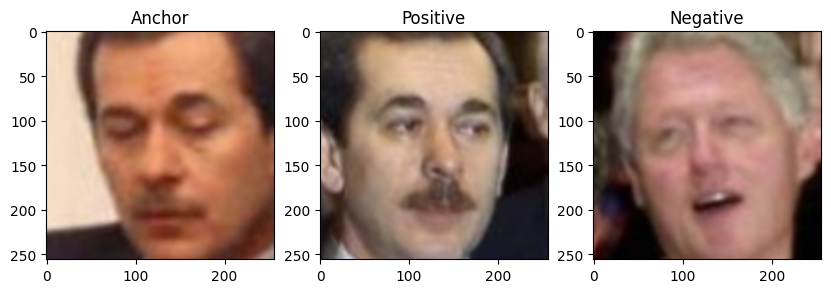

In [92]:
for x in dataset.take(1):
    plt.figure(figsize=(10, 5))
    plt.subplot(131)
    plt.title("Anchor")
    plt.imshow(x[0].numpy() / 255)
    plt.subplot(132)
    plt.title("Positive")
    plt.imshow(x[1].numpy() / 255)
    plt.subplot(133)
    plt.title("Negative")
    plt.imshow(x[2].numpy() / 255)
    plt.show()

In [7]:
train_dataset_size = int((DATA_SIZE * (1 - VAL_SPLIT)) // BATCH_SIZE)
val_dataset_size = int((DATA_SIZE * VAL_SPLIT) // BATCH_SIZE)
train_dataset = dataset.batch(BATCH_SIZE)
val_dataset = dataset.batch(BATCH_SIZE)

## Making model

In [74]:
def make_encoder_model():
    encoder = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3))
    encoder.trainable = False
    
    x = tf.keras.layers.Input(shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3))
    y = encoder(x)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Dropout(0.7)(y)
    y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(y)
    y = tf.keras.layers.BatchNormalization()(y)
    
    return tf.keras.Model(inputs=x, outputs=y, name='Encoder')

class DistanceLayer(tf.keras.layers.Layer):
    def call(self, ae, pe, ne):
        return tf.reduce_sum(tf.square(ae - pe), 1), tf.reduce_sum(tf.square(ae - ne), axis=-1)

def get_siamese_model(encoder):
    a = tf.keras.layers.Input(shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3), name='anchor')
    p = tf.keras.layers.Input(shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3), name='positive')
    n = tf.keras.layers.Input(shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3), name='negative')
       
    ae = encoder(a)
    pe = encoder(p)
    ne = encoder(n)
    
    return tf.keras.Model(
        inputs=[a, p, n],
        outputs=DistanceLayer()(ae, pe, ne),
        name='Siamese'
    )
    

In [75]:
encoder = make_encoder_model()
encoder.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:449: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3small (Functional)   │ (None, 8, 8, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,882,224 (75.84 MB)

 Trainable params: 18,941,824 (72.26 MB)

 Non-trainable params: 940,400 (3.59 MB)

In [76]:
siamese_model = get_siamese_model(encoder)
siamese_model.summary()

Model: "Siamese"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive            │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative            │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder             │ (None, 128)       │ 19,882,224 │ anchor[0][0],     │
│ (Functional)        │                   │            │ positive[0][0],   │
│                     │                   │            │ negative[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance_layer_6    │ [(None), (None)]  │          0 │ Encoder[0][0],    │
│ (DistanceLayer)     │                   │            │ Encoder[1][0],    │
│                     │                   │            │ Encoder[2][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,882,224 (75.84 MB)

 Trainable params: 18,941,824 (72.26 MB)

 Non-trainable params: 940,400 (3.59 MB)

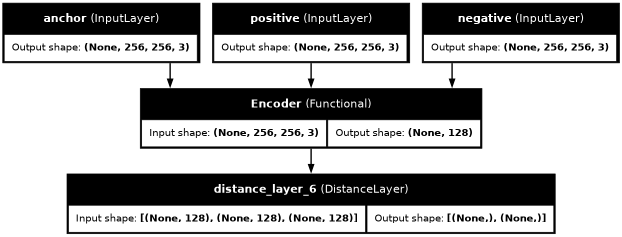

In [77]:
plot_model(siamese_model, show_shapes=True, show_layer_names=True, dpi=50)

### Training

In [79]:
opt = tf.keras.optimizers.Adam()

In [80]:
def triplet_loss(ap, an):
    loss = tf.maximum(ap - an + 1, 0.0)
    return tf.reduce_mean(loss)

@tf.function()
def train_step(x):
    with tf.GradientTape() as tape:
        ap, an = siamese_model(x, training=True)
        loss = triplet_loss(ap, an)
    
    gradients = tape.gradient(loss, siamese_model.trainable_weights)
    opt.apply_gradients(zip(gradients, siamese_model.trainable_weights))
    return loss

In [85]:
loss = []
val_loss = []
for _ in tqdm(range(EPOCHS)):
    epoch_loss = []
    for b in tqdm(train_dataset.take(train_dataset_size)):
        batch_loss = train_step(b)
        epoch_loss.append(batch_loss)
    loss.append(sum(epoch_loss) / len(epoch_loss))
    print('Training loss', sum(epoch_loss) / len(epoch_loss))
    
    epoch_loss = []
    for b in tqdm(val_dataset.take(val_dataset_size)):
        ap, an = siamese_model(b)
        batch_loss = triplet_loss(ap, an)
        epoch_loss.append(batch_loss)
    val_loss.append(sum(epoch_loss) / len(epoch_loss))
    print('Validation Loss', sum(epoch_loss) / len(epoch_loss))

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  3.34it/s]
2it [00:00,  3.98it/s]
3it [00:00,  4.26it/s]
4it [00:00,  4.33it/s]
5it [00:01,  4.41it/s]
6it [00:01,  4.36it/s]
7it [00:01,  4.34it/s]
8it [00:01,  4.29it/s]
9it [00:02,  4.13it/s]
10it [00:02,  4.22it/s]
11it [00:02,  4.37it/s]
12it [00:02,  4.38it/s]
13it [00:03,  4.44it/s]
14it [00:03,  4.49it/s]
15it [00:03,  4.55it/s]
16it [00:03,  4.60it/s]
17it [00:03,  4.50it/s]
18it [00:04,  4.43it/s]
19it [00:04,  4.36it/s]
20it [00:04,  4.41it/s]
21it [00:04,  4.47it/s]
22it [00:05,  4.51it/s]
23it [00:05,  4.51it/s]
24it [00:05,  4.51it/s]
25it [00:05,  4.55it/s]
26it [00:05,  4.59it/s]
27it [00:06,  4.57it/s]
28it [00:06,  4.53it/s]
29it [00:06,  4.51it/s]
30it [00:06,  4.57it/s]
31it [00:06,  4.60it/s]
32it [00:07,  4.59it/s]
33it [00:07,  4.54it/s]
34it [00:07,  4.48it/s]
35it [00:07,  4.46it/s]
36it [00:08,  4.51it/s]
37it [00:08,  4.45it/s]
38it [00:08,  4.51it/s]
39it [00:08,  4.45it/s]
40it [00:09,  4

Training loss tf.Tensor(0.93261987, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  1.33it/s]
2it [00:01,  1.63it/s]
3it [00:01,  1.77it/s]
4it [00:02,  1.84it/s]
5it [00:02,  1.84it/s]
6it [00:03,  1.88it/s]
7it [00:03,  1.90it/s]
8it [00:04,  1.90it/s]
9it [00:04,  1.91it/s]
10it [00:05,  1.89it/s]
11it [00:05,  1.90it/s]
12it [00:06,  1.93it/s]
13it [00:07,  1.90it/s]
14it [00:07,  1.92it/s]
15it [00:08,  1.95it/s]
16it [00:08,  1.95it/s]
17it [00:09,  1.95it/s]
18it [00:09,  1.96it/s]
19it [00:10,  1.97it/s]
20it [00:10,  1.96it/s]
21it [00:11,  1.94it/s]
22it [00:11,  1.93it/s]
23it [00:12,  1.94it/s]
24it [00:12,  1.93it/s]
25it [00:13,  1.89it/s]
26it [00:13,  1.89it/s]
27it [00:14,  1.90it/s]
28it [00:14,  1.90it/s]
29it [00:15,  1.90it/s]
30it [00:15,  1.91it/s]
31it [00:16,  1.92it/s]
32it [00:16,  1.94it/s]
33it [00:17,  1.89it/s]
34it [00:17,  1.88it/s]
35it [00:18,  1.89it/s]
36it [00:19,  1.88it/s]
37it [00:19,  1.90it/s]
38it [00:20,  1.90it/s]
39it [00:20,  1.93it/s]
40it [00:21,  1.95it/s]
41it [00:21,  1.95it/s]
42it 

Validation Loss tf.Tensor(8.148536, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  3.35it/s]
2it [00:00,  3.71it/s]
3it [00:00,  3.97it/s]
4it [00:01,  4.04it/s]
5it [00:01,  3.84it/s]
6it [00:01,  4.03it/s]
7it [00:01,  4.15it/s]
8it [00:01,  4.13it/s]
9it [00:02,  4.22it/s]
10it [00:02,  4.21it/s]
11it [00:02,  4.18it/s]
12it [00:02,  4.18it/s]
13it [00:03,  4.29it/s]
14it [00:03,  4.26it/s]
15it [00:03,  4.20it/s]
16it [00:03,  4.11it/s]
17it [00:04,  3.84it/s]
18it [00:04,  3.74it/s]
19it [00:04,  3.89it/s]
20it [00:04,  4.03it/s]
21it [00:05,  4.08it/s]
22it [00:05,  4.11it/s]
23it [00:05,  4.24it/s]
24it [00:05,  4.19it/s]
25it [00:06,  4.11it/s]
26it [00:06,  4.20it/s]
27it [00:06,  4.21it/s]
28it [00:06,  4.23it/s]
29it [00:07,  4.20it/s]
30it [00:07,  4.22it/s]
31it [00:07,  4.24it/s]
32it [00:07,  4.03it/s]
33it [00:08,  4.08it/s]
34it [00:08,  4.16it/s]
35it [00:08,  4.07it/s]
36it [00:08,  4.06it/s]
37it [00:09,  4.17it/s]
38it [00:09,  4.30it/s]
39it [00:09,  4.35it/s]
40it [00:09,  4.33it/s]
41it [00:09,  4.46it/s]
42it 

Training loss tf.Tensor(0.9119455, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  1.25it/s]
2it [00:01,  1.50it/s]
3it [00:01,  1.63it/s]
4it [00:02,  1.70it/s]
5it [00:02,  1.77it/s]
6it [00:03,  1.85it/s]
7it [00:04,  1.87it/s]
8it [00:04,  1.90it/s]
9it [00:05,  1.88it/s]
10it [00:05,  1.86it/s]
11it [00:06,  1.92it/s]
12it [00:06,  1.90it/s]
13it [00:07,  1.92it/s]
14it [00:07,  1.91it/s]
15it [00:08,  1.89it/s]
16it [00:08,  1.90it/s]
17it [00:09,  1.92it/s]
18it [00:09,  1.94it/s]
19it [00:10,  1.92it/s]
20it [00:10,  1.92it/s]
21it [00:11,  1.92it/s]
22it [00:11,  1.93it/s]
23it [00:12,  1.94it/s]
24it [00:12,  1.93it/s]
25it [00:13,  1.92it/s]
26it [00:13,  1.92it/s]
27it [00:14,  1.94it/s]
28it [00:14,  1.92it/s]
29it [00:15,  1.90it/s]
30it [00:16,  1.90it/s]
31it [00:16,  1.90it/s]
32it [00:17,  1.94it/s]
33it [00:17,  1.91it/s]
34it [00:18,  1.89it/s]
35it [00:18,  1.91it/s]
36it [00:19,  1.93it/s]
37it [00:19,  1.94it/s]
38it [00:20,  1.96it/s]
39it [00:20,  1.95it/s]
40it [00:21,  1.91it/s]
41it [00:21,  1.88it/s]
42it 

Validation Loss tf.Tensor(1.0321982, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  3.13it/s]
2it [00:00,  3.56it/s]
3it [00:00,  3.74it/s]
4it [00:01,  3.68it/s]
5it [00:01,  3.97it/s]
6it [00:01,  4.14it/s]
7it [00:01,  4.30it/s]
8it [00:01,  4.37it/s]
9it [00:02,  4.35it/s]
10it [00:02,  4.44it/s]
11it [00:02,  4.49it/s]
12it [00:02,  4.47it/s]
13it [00:03,  4.39it/s]
14it [00:03,  4.42it/s]
15it [00:03,  4.52it/s]
16it [00:03,  4.57it/s]
17it [00:03,  4.49it/s]
18it [00:04,  4.47it/s]
19it [00:04,  4.54it/s]
20it [00:04,  4.47it/s]
21it [00:04,  4.56it/s]
22it [00:05,  4.50it/s]
23it [00:05,  4.44it/s]
24it [00:05,  4.41it/s]
25it [00:05,  4.38it/s]
26it [00:06,  4.35it/s]
27it [00:06,  4.45it/s]
28it [00:06,  4.44it/s]
29it [00:06,  4.44it/s]
30it [00:06,  4.55it/s]
31it [00:07,  4.55it/s]
32it [00:07,  4.43it/s]
33it [00:07,  4.47it/s]
34it [00:07,  4.56it/s]
35it [00:07,  4.64it/s]
36it [00:08,  4.67it/s]
37it [00:08,  4.66it/s]
38it [00:08,  4.62it/s]
39it [00:08,  4.67it/s]
40it [00:09,  4.63it/s]
41it [00:09,  4.57it/s]
42it 

Training loss tf.Tensor(0.769404, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  1.26it/s]
2it [00:01,  1.57it/s]
3it [00:01,  1.74it/s]
4it [00:02,  1.80it/s]
5it [00:02,  1.88it/s]
6it [00:03,  1.86it/s]
7it [00:03,  1.90it/s]
8it [00:04,  1.95it/s]
9it [00:04,  1.95it/s]
10it [00:05,  1.95it/s]
11it [00:05,  1.97it/s]
12it [00:06,  1.98it/s]
13it [00:06,  1.96it/s]
14it [00:07,  1.92it/s]
15it [00:08,  1.86it/s]
16it [00:08,  1.84it/s]
17it [00:09,  1.84it/s]
18it [00:09,  1.86it/s]
19it [00:10,  1.87it/s]
20it [00:10,  1.91it/s]
21it [00:11,  1.92it/s]
22it [00:11,  1.93it/s]
23it [00:12,  1.97it/s]
24it [00:12,  1.95it/s]
25it [00:13,  1.98it/s]
26it [00:13,  1.96it/s]
27it [00:14,  1.97it/s]
28it [00:14,  1.97it/s]
29it [00:15,  1.99it/s]
30it [00:15,  1.98it/s]
31it [00:16,  1.98it/s]
32it [00:16,  1.92it/s]
33it [00:17,  1.94it/s]
34it [00:17,  1.94it/s]
35it [00:18,  1.94it/s]
36it [00:18,  1.92it/s]
37it [00:19,  1.92it/s]
38it [00:19,  1.93it/s]
39it [00:20,  1.92it/s]
40it [00:20,  1.93it/s]
41it [00:21,  1.93it/s]
42it 

Validation Loss tf.Tensor(1.153519, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  3.32it/s]
2it [00:00,  3.80it/s]
3it [00:00,  4.13it/s]
4it [00:00,  4.28it/s]
5it [00:01,  4.21it/s]
6it [00:01,  4.27it/s]
7it [00:01,  4.29it/s]
8it [00:01,  4.31it/s]
9it [00:02,  4.38it/s]
10it [00:02,  4.40it/s]
11it [00:02,  4.47it/s]
12it [00:02,  4.51it/s]
13it [00:03,  4.50it/s]
14it [00:03,  4.49it/s]
15it [00:03,  4.51it/s]
16it [00:03,  4.41it/s]
17it [00:03,  4.26it/s]
18it [00:04,  4.15it/s]
19it [00:04,  4.24it/s]
20it [00:04,  4.34it/s]
21it [00:04,  4.38it/s]
22it [00:05,  4.46it/s]
23it [00:05,  4.43it/s]
24it [00:05,  4.39it/s]
25it [00:05,  4.41it/s]
26it [00:05,  4.50it/s]
27it [00:06,  4.46it/s]
28it [00:06,  4.49it/s]
29it [00:06,  4.57it/s]
30it [00:06,  4.35it/s]
31it [00:07,  4.13it/s]
32it [00:07,  4.02it/s]
33it [00:07,  4.01it/s]
34it [00:07,  4.02it/s]
35it [00:08,  4.12it/s]
36it [00:08,  4.27it/s]
37it [00:08,  4.36it/s]
38it [00:08,  4.33it/s]
39it [00:09,  4.34it/s]
40it [00:09,  4.39it/s]
41it [00:09,  4.33it/s]
42it 

Training loss tf.Tensor(0.73719543, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  1.26it/s]
2it [00:01,  1.52it/s]
3it [00:01,  1.66it/s]
4it [00:02,  1.73it/s]
5it [00:02,  1.78it/s]
6it [00:03,  1.83it/s]
7it [00:04,  1.84it/s]
8it [00:04,  1.84it/s]
9it [00:05,  1.85it/s]
10it [00:05,  1.88it/s]
11it [00:06,  1.88it/s]
12it [00:06,  1.88it/s]
13it [00:07,  1.87it/s]
14it [00:07,  1.87it/s]
15it [00:08,  1.88it/s]
16it [00:08,  1.89it/s]
17it [00:09,  1.83it/s]
18it [00:09,  1.84it/s]
19it [00:10,  1.83it/s]
20it [00:11,  1.84it/s]
21it [00:11,  1.86it/s]
22it [00:12,  1.87it/s]
23it [00:12,  1.88it/s]
24it [00:13,  1.89it/s]
25it [00:13,  1.88it/s]
26it [00:14,  1.89it/s]
27it [00:14,  1.91it/s]
28it [00:15,  1.84it/s]
29it [00:15,  1.79it/s]
30it [00:16,  1.76it/s]
31it [00:16,  1.81it/s]
32it [00:17,  1.84it/s]
33it [00:18,  1.87it/s]
34it [00:18,  1.90it/s]
35it [00:19,  1.91it/s]
36it [00:19,  1.89it/s]
37it [00:20,  1.90it/s]
38it [00:20,  1.92it/s]
39it [00:21,  1.93it/s]
40it [00:21,  1.92it/s]
41it [00:22,  1.88it/s]
42it 

Validation Loss tf.Tensor(0.95375055, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  3.52it/s]
2it [00:00,  4.06it/s]
3it [00:00,  4.30it/s]
4it [00:00,  4.42it/s]
5it [00:01,  4.50it/s]
6it [00:01,  4.53it/s]
7it [00:01,  4.56it/s]
8it [00:01,  4.44it/s]
9it [00:02,  4.44it/s]
10it [00:02,  4.40it/s]
11it [00:02,  4.39it/s]
12it [00:02,  4.37it/s]
13it [00:02,  4.47it/s]
14it [00:03,  4.48it/s]
15it [00:03,  4.55it/s]
16it [00:03,  4.55it/s]
17it [00:03,  4.59it/s]
18it [00:04,  4.59it/s]
19it [00:04,  4.59it/s]
20it [00:04,  4.58it/s]
21it [00:04,  4.62it/s]
22it [00:04,  4.57it/s]
23it [00:05,  4.62it/s]
24it [00:05,  4.66it/s]
25it [00:05,  4.67it/s]
26it [00:05,  4.66it/s]
27it [00:05,  4.59it/s]
28it [00:06,  4.53it/s]
29it [00:06,  4.52it/s]
30it [00:06,  4.34it/s]
31it [00:06,  4.28it/s]
32it [00:07,  4.24it/s]
33it [00:07,  4.25it/s]
34it [00:07,  4.27it/s]
35it [00:07,  4.22it/s]
36it [00:08,  4.16it/s]
37it [00:08,  4.18it/s]
38it [00:08,  4.20it/s]
39it [00:08,  4.04it/s]
40it [00:09,  3.90it/s]
41it [00:09,  3.94it/s]
42it 

Training loss tf.Tensor(0.6138804, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  1.29it/s]
2it [00:01,  1.54it/s]
3it [00:01,  1.65it/s]
4it [00:02,  1.70it/s]
5it [00:03,  1.73it/s]
6it [00:03,  1.76it/s]
7it [00:04,  1.77it/s]
8it [00:04,  1.80it/s]
9it [00:05,  1.82it/s]
10it [00:05,  1.86it/s]
11it [00:06,  1.88it/s]
12it [00:06,  1.90it/s]
13it [00:07,  1.93it/s]
14it [00:07,  1.92it/s]
15it [00:08,  1.92it/s]
16it [00:08,  1.91it/s]
17it [00:09,  1.92it/s]
18it [00:09,  1.91it/s]
19it [00:10,  1.91it/s]
20it [00:10,  1.94it/s]
21it [00:11,  1.96it/s]
22it [00:11,  1.93it/s]
23it [00:12,  1.94it/s]
24it [00:12,  1.96it/s]
25it [00:13,  1.93it/s]
26it [00:14,  1.89it/s]
27it [00:14,  1.89it/s]
28it [00:15,  1.92it/s]
29it [00:15,  1.91it/s]
30it [00:16,  1.94it/s]
31it [00:16,  1.95it/s]
32it [00:17,  1.95it/s]
33it [00:17,  1.98it/s]
34it [00:18,  1.99it/s]
35it [00:18,  1.96it/s]
36it [00:19,  1.93it/s]
37it [00:19,  1.94it/s]
38it [00:20,  1.91it/s]
39it [00:20,  1.87it/s]
40it [00:21,  1.84it/s]
41it [00:21,  1.87it/s]
42it 

Validation Loss tf.Tensor(0.8158671, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  3.53it/s]
2it [00:00,  3.92it/s]
3it [00:00,  3.99it/s]
4it [00:00,  4.10it/s]
5it [00:01,  4.28it/s]
6it [00:01,  4.27it/s]
7it [00:01,  4.29it/s]
8it [00:01,  4.19it/s]
9it [00:02,  4.26it/s]
10it [00:02,  4.28it/s]
11it [00:02,  4.37it/s]
12it [00:02,  4.19it/s]
13it [00:03,  4.31it/s]
14it [00:03,  4.35it/s]
15it [00:03,  4.30it/s]
16it [00:03,  4.22it/s]
17it [00:04,  4.35it/s]
18it [00:04,  4.34it/s]
19it [00:04,  4.30it/s]
20it [00:04,  4.25it/s]
21it [00:04,  4.21it/s]
22it [00:05,  4.33it/s]
23it [00:05,  4.30it/s]
24it [00:05,  4.31it/s]
25it [00:05,  4.21it/s]
26it [00:06,  3.90it/s]
27it [00:06,  3.78it/s]
28it [00:06,  3.96it/s]
29it [00:06,  4.01it/s]
30it [00:07,  3.95it/s]
31it [00:07,  3.96it/s]
32it [00:07,  4.01it/s]
33it [00:07,  4.06it/s]
34it [00:08,  3.95it/s]
35it [00:08,  4.02it/s]
36it [00:08,  4.15it/s]
37it [00:08,  4.08it/s]
38it [00:09,  4.06it/s]
39it [00:09,  3.95it/s]
40it [00:09,  3.63it/s]
41it [00:10,  3.66it/s]
42it 

Training loss tf.Tensor(0.54344904, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  1.28it/s]
2it [00:01,  1.53it/s]
3it [00:01,  1.69it/s]
4it [00:02,  1.78it/s]
5it [00:02,  1.84it/s]
6it [00:03,  1.87it/s]
7it [00:03,  1.89it/s]
8it [00:04,  1.88it/s]
9it [00:05,  1.85it/s]
10it [00:05,  1.84it/s]
11it [00:06,  1.85it/s]
12it [00:06,  1.87it/s]
13it [00:07,  1.88it/s]
14it [00:07,  1.86it/s]
15it [00:08,  1.87it/s]
16it [00:08,  1.82it/s]
17it [00:09,  1.86it/s]
18it [00:09,  1.88it/s]
19it [00:10,  1.89it/s]
20it [00:10,  1.88it/s]
21it [00:11,  1.90it/s]
22it [00:11,  1.90it/s]
23it [00:12,  1.90it/s]
24it [00:12,  1.93it/s]
25it [00:13,  1.91it/s]
26it [00:14,  1.90it/s]
27it [00:14,  1.92it/s]
28it [00:15,  1.94it/s]
29it [00:15,  1.94it/s]
30it [00:16,  1.91it/s]
31it [00:16,  1.95it/s]
32it [00:17,  1.98it/s]
33it [00:17,  1.97it/s]
34it [00:18,  1.98it/s]
35it [00:18,  1.94it/s]
36it [00:19,  1.95it/s]
37it [00:19,  1.94it/s]
38it [00:20,  1.94it/s]
39it [00:20,  1.96it/s]
40it [00:21,  1.99it/s]
41it [00:21,  1.97it/s]
42it 

Validation Loss tf.Tensor(0.70802623, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  3.57it/s]
2it [00:00,  4.09it/s]
3it [00:00,  4.21it/s]
4it [00:00,  4.21it/s]
5it [00:01,  4.34it/s]
6it [00:01,  4.49it/s]
7it [00:01,  4.47it/s]
8it [00:01,  4.52it/s]
9it [00:02,  4.54it/s]
10it [00:02,  4.49it/s]
11it [00:02,  4.55it/s]
12it [00:02,  4.57it/s]
13it [00:02,  4.62it/s]
14it [00:03,  4.59it/s]
15it [00:03,  4.61it/s]
16it [00:03,  4.60it/s]
17it [00:03,  4.66it/s]
18it [00:03,  4.66it/s]
19it [00:04,  4.61it/s]
20it [00:04,  4.56it/s]
21it [00:04,  4.63it/s]
22it [00:04,  4.66it/s]
23it [00:05,  4.71it/s]
24it [00:05,  4.72it/s]
25it [00:05,  4.76it/s]
26it [00:05,  4.74it/s]
27it [00:05,  4.71it/s]
28it [00:06,  4.60it/s]
29it [00:06,  4.62it/s]
30it [00:06,  4.63it/s]
31it [00:06,  4.63it/s]
32it [00:07,  4.67it/s]
33it [00:07,  4.57it/s]
34it [00:07,  4.55it/s]
35it [00:07,  4.53it/s]
36it [00:07,  4.56it/s]
37it [00:08,  4.59it/s]
38it [00:08,  4.54it/s]
39it [00:08,  4.53it/s]
40it [00:08,  4.37it/s]
41it [00:09,  4.27it/s]
42it 

Training loss tf.Tensor(0.5093007, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  1.25it/s]
2it [00:01,  1.56it/s]
3it [00:01,  1.69it/s]
4it [00:02,  1.78it/s]
5it [00:02,  1.84it/s]
6it [00:03,  1.86it/s]
7it [00:03,  1.90it/s]
8it [00:04,  1.93it/s]
9it [00:04,  1.95it/s]
10it [00:05,  1.94it/s]
11it [00:05,  1.94it/s]
12it [00:06,  1.92it/s]
13it [00:06,  1.95it/s]
14it [00:07,  1.95it/s]
15it [00:08,  1.94it/s]
16it [00:08,  1.91it/s]
17it [00:09,  1.90it/s]
18it [00:09,  1.89it/s]
19it [00:10,  1.87it/s]
20it [00:10,  1.89it/s]
21it [00:11,  1.92it/s]
22it [00:11,  1.89it/s]
23it [00:12,  1.90it/s]
24it [00:12,  1.92it/s]
25it [00:13,  1.93it/s]
26it [00:13,  1.95it/s]
27it [00:14,  1.93it/s]
28it [00:14,  1.90it/s]
29it [00:15,  1.92it/s]
30it [00:15,  1.91it/s]
31it [00:16,  1.91it/s]
32it [00:16,  1.89it/s]
33it [00:17,  1.90it/s]
34it [00:17,  1.93it/s]
35it [00:18,  1.91it/s]
36it [00:19,  1.91it/s]
37it [00:19,  1.94it/s]
38it [00:20,  1.94it/s]
39it [00:20,  1.94it/s]
40it [00:21,  1.95it/s]
41it [00:21,  1.97it/s]
42it 

Validation Loss tf.Tensor(0.3244405, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  3.18it/s]
2it [00:00,  3.88it/s]
3it [00:00,  4.17it/s]
4it [00:00,  4.17it/s]
5it [00:01,  4.27it/s]
6it [00:01,  4.27it/s]
7it [00:01,  4.34it/s]
8it [00:01,  4.31it/s]
9it [00:02,  4.40it/s]
10it [00:02,  4.43it/s]
11it [00:02,  4.42it/s]
12it [00:02,  4.46it/s]
13it [00:03,  4.53it/s]
14it [00:03,  4.64it/s]
15it [00:03,  4.67it/s]
16it [00:03,  4.63it/s]
17it [00:03,  4.60it/s]
18it [00:04,  4.62it/s]
19it [00:04,  4.65it/s]
20it [00:04,  4.68it/s]
21it [00:04,  4.46it/s]
22it [00:04,  4.56it/s]
23it [00:05,  4.43it/s]
24it [00:05,  4.47it/s]
25it [00:05,  4.39it/s]
26it [00:05,  4.41it/s]
27it [00:06,  4.33it/s]
28it [00:06,  4.39it/s]
29it [00:06,  4.38it/s]
30it [00:06,  4.39it/s]
31it [00:07,  4.41it/s]
32it [00:07,  4.44it/s]
33it [00:07,  4.40it/s]
34it [00:07,  4.34it/s]
35it [00:07,  4.37it/s]
36it [00:08,  4.32it/s]
37it [00:08,  4.20it/s]
38it [00:08,  4.12it/s]
39it [00:08,  4.15it/s]
40it [00:09,  4.18it/s]
41it [00:09,  4.31it/s]
42it 

Training loss tf.Tensor(0.46787012, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  1.26it/s]
2it [00:01,  1.56it/s]
3it [00:01,  1.69it/s]
4it [00:02,  1.75it/s]
5it [00:02,  1.79it/s]
6it [00:03,  1.85it/s]
7it [00:03,  1.86it/s]
8it [00:04,  1.82it/s]
9it [00:05,  1.79it/s]
10it [00:05,  1.79it/s]
11it [00:06,  1.79it/s]
12it [00:06,  1.84it/s]
13it [00:07,  1.88it/s]
14it [00:07,  1.89it/s]
15it [00:08,  1.86it/s]
16it [00:08,  1.88it/s]
17it [00:09,  1.87it/s]
18it [00:09,  1.86it/s]
19it [00:10,  1.84it/s]
20it [00:11,  1.85it/s]
21it [00:11,  1.86it/s]
22it [00:12,  1.86it/s]
23it [00:12,  1.86it/s]
24it [00:13,  1.87it/s]
25it [00:13,  1.88it/s]
26it [00:14,  1.88it/s]
27it [00:14,  1.88it/s]
28it [00:15,  1.88it/s]
29it [00:15,  1.91it/s]
30it [00:16,  1.91it/s]
31it [00:16,  1.92it/s]
32it [00:17,  1.93it/s]
33it [00:17,  1.91it/s]
34it [00:18,  1.89it/s]
35it [00:18,  1.90it/s]
36it [00:19,  1.90it/s]
37it [00:19,  1.91it/s]
38it [00:20,  1.87it/s]
39it [00:21,  1.89it/s]
40it [00:21,  1.86it/s]
41it [00:22,  1.90it/s]
42it 

Validation Loss tf.Tensor(0.86964506, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  3.37it/s]
2it [00:00,  3.82it/s]
3it [00:00,  4.10it/s]
4it [00:00,  4.26it/s]
5it [00:01,  4.42it/s]
6it [00:01,  4.51it/s]
7it [00:01,  4.53it/s]
8it [00:01,  4.59it/s]
9it [00:02,  4.56it/s]
10it [00:02,  4.72it/s]
11it [00:02,  4.72it/s]
12it [00:02,  4.78it/s]
13it [00:02,  4.80it/s]
14it [00:03,  4.72it/s]
15it [00:03,  4.42it/s]
16it [00:03,  4.32it/s]
17it [00:03,  3.99it/s]
18it [00:04,  3.95it/s]
19it [00:04,  3.99it/s]
20it [00:04,  4.03it/s]
21it [00:04,  3.64it/s]
22it [00:05,  3.79it/s]
23it [00:05,  3.96it/s]
24it [00:05,  4.04it/s]
25it [00:05,  4.20it/s]
26it [00:06,  4.36it/s]
27it [00:06,  4.49it/s]
28it [00:06,  4.56it/s]
29it [00:06,  4.61it/s]
30it [00:06,  4.37it/s]
31it [00:07,  4.49it/s]
32it [00:07,  4.55it/s]
33it [00:07,  4.64it/s]
34it [00:07,  4.70it/s]
35it [00:08,  4.68it/s]
36it [00:08,  4.59it/s]
37it [00:08,  4.64it/s]
38it [00:08,  4.66it/s]
39it [00:08,  4.72it/s]
40it [00:09,  4.78it/s]
41it [00:09,  4.82it/s]
42it 

Training loss tf.Tensor(0.45957768, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  1.17it/s]
2it [00:01,  1.50it/s]
3it [00:01,  1.66it/s]
4it [00:02,  1.77it/s]
5it [00:02,  1.79it/s]
6it [00:03,  1.81it/s]
7it [00:04,  1.83it/s]
8it [00:04,  1.87it/s]
9it [00:05,  1.90it/s]
10it [00:05,  1.84it/s]
11it [00:06,  1.77it/s]
12it [00:06,  1.78it/s]
13it [00:07,  1.81it/s]
14it [00:07,  1.81it/s]
15it [00:08,  1.83it/s]
16it [00:08,  1.85it/s]
17it [00:09,  1.86it/s]
18it [00:10,  1.88it/s]
19it [00:10,  1.89it/s]
20it [00:11,  1.90it/s]
21it [00:11,  1.93it/s]
22it [00:12,  1.93it/s]
23it [00:12,  1.93it/s]
24it [00:13,  1.93it/s]
25it [00:13,  1.96it/s]
26it [00:14,  1.92it/s]
27it [00:14,  1.91it/s]
28it [00:15,  1.90it/s]
29it [00:15,  1.89it/s]
30it [00:16,  1.86it/s]
31it [00:16,  1.88it/s]
32it [00:17,  1.91it/s]
33it [00:17,  1.88it/s]
34it [00:18,  1.90it/s]
35it [00:18,  1.89it/s]
36it [00:19,  1.89it/s]
37it [00:19,  1.89it/s]
38it [00:20,  1.92it/s]
39it [00:21,  1.92it/s]
40it [00:21,  1.90it/s]
41it [00:22,  1.86it/s]
42it 

Validation Loss tf.Tensor(1.1282463, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  3.44it/s]
2it [00:00,  3.85it/s]
3it [00:00,  4.12it/s]
4it [00:00,  4.12it/s]
5it [00:01,  4.28it/s]
6it [00:01,  4.36it/s]
7it [00:01,  4.40it/s]
8it [00:01,  4.41it/s]
9it [00:02,  4.33it/s]
10it [00:02,  4.19it/s]
11it [00:02,  4.23it/s]
12it [00:02,  4.20it/s]
13it [00:03,  4.10it/s]
14it [00:03,  4.14it/s]
15it [00:03,  4.24it/s]
16it [00:03,  4.20it/s]
17it [00:04,  4.12it/s]
18it [00:04,  4.04it/s]
19it [00:04,  3.92it/s]
20it [00:04,  3.80it/s]
21it [00:05,  3.73it/s]
22it [00:05,  3.88it/s]
23it [00:05,  3.99it/s]
24it [00:05,  3.79it/s]
25it [00:06,  3.84it/s]
26it [00:06,  4.04it/s]
27it [00:06,  4.17it/s]
28it [00:06,  4.20it/s]
29it [00:07,  4.22it/s]
30it [00:07,  4.23it/s]
31it [00:07,  4.21it/s]
32it [00:07,  4.21it/s]
33it [00:08,  4.25it/s]
34it [00:08,  4.27it/s]
35it [00:08,  4.29it/s]
36it [00:08,  4.37it/s]
37it [00:08,  4.25it/s]
38it [00:09,  4.38it/s]
39it [00:09,  4.37it/s]
40it [00:09,  4.28it/s]
41it [00:09,  4.33it/s]
42it 

Training loss tf.Tensor(0.39532033, shape=(), dtype=float32)



0it [00:00, ?it/s]
1it [00:00,  1.27it/s]
2it [00:01,  1.55it/s]
3it [00:01,  1.69it/s]
4it [00:02,  1.74it/s]
5it [00:02,  1.82it/s]
6it [00:03,  1.83it/s]
7it [00:04,  1.83it/s]
8it [00:04,  1.86it/s]
9it [00:05,  1.88it/s]
10it [00:05,  1.87it/s]
11it [00:06,  1.85it/s]
12it [00:06,  1.85it/s]
13it [00:07,  1.89it/s]
14it [00:07,  1.89it/s]
15it [00:08,  1.93it/s]
16it [00:08,  1.93it/s]
17it [00:09,  1.88it/s]
18it [00:09,  1.86it/s]
19it [00:10,  1.82it/s]
20it [00:10,  1.78it/s]
21it [00:11,  1.77it/s]
22it [00:12,  1.80it/s]
23it [00:12,  1.84it/s]
24it [00:13,  1.87it/s]
25it [00:13,  1.86it/s]
26it [00:14,  1.83it/s]
27it [00:14,  1.83it/s]
28it [00:15,  1.88it/s]
29it [00:15,  1.90it/s]
30it [00:16,  1.87it/s]
31it [00:16,  1.87it/s]
32it [00:17,  1.85it/s]
33it [00:17,  1.84it/s]
34it [00:18,  1.85it/s]
35it [00:19,  1.85it/s]
36it [00:19,  1.87it/s]
37it [00:20,  1.84it/s]
38it [00:20,  1.86it/s]
39it [00:21,  1.91it/s]
40it [00:21,  1.91it/s]
41it [00:22,  1.93it/s]
42it 

Validation Loss tf.Tensor(0.22547899, shape=(), dtype=float32)


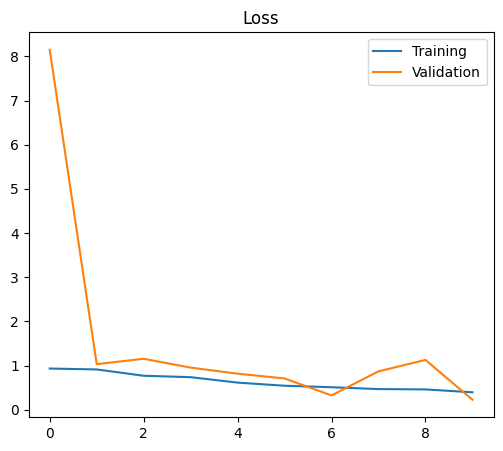

In [86]:
plt.figure(figsize=(6, 5))

_num_epochs = [i for i in range(EPOCHS)]
plt.title("Loss")
plt.plot(_num_epochs, loss)
plt.plot(_num_epochs, val_loss)
plt.legend(['Training', 'Validation'])

plt.show()

In [87]:
encoder.save("encoder.keras")

In [88]:
from IPython.display import FileLink
FileLink("encoder.keras")

/kaggle/working/encoder.keras